In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')

In [56]:
data = yf.download('AAPL', start='2015-01-01', end='2025-05-08')
data.reset_index(inplace=True)
data = data[['Date', 'Close']]
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [57]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.rename(columns={'Date': 'ds', 'Close': 'y'})
data.set_index('ds', inplace=True)

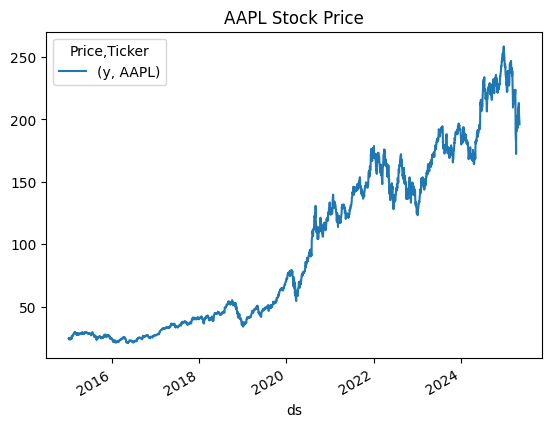

In [58]:
data.plot(title='AAPL Stock Price')
plt.show()

In [59]:
result = adfuller(data['y'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -0.3877177395110981
p-value: 0.9121293658016747


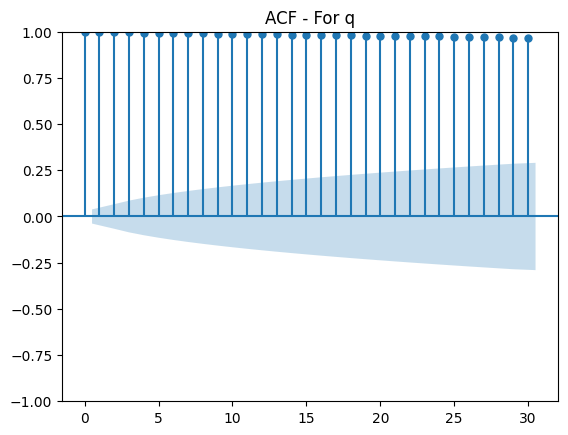

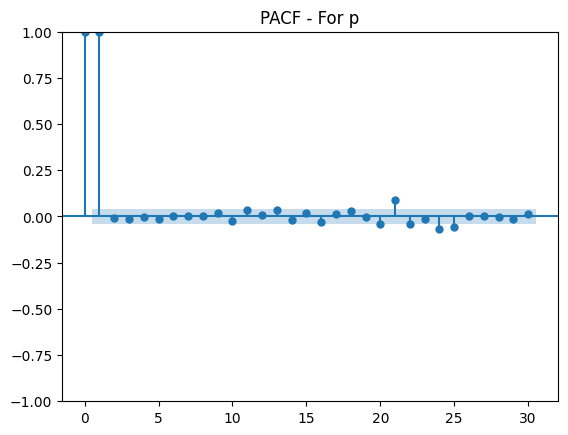

In [60]:
plot_acf(data['y'].dropna(), lags=30)
plt.title("ACF - For q")
plt.show()
plot_pacf(data['y'].dropna(), lags=30)
plt.title("PACF - For p")
plt.show()

In [61]:
model_arima = ARIMA(data['y'], order=(5,1,0))
result_arima = model_arima.fit()
forecast_arima = result_arima.forecast(steps=30)

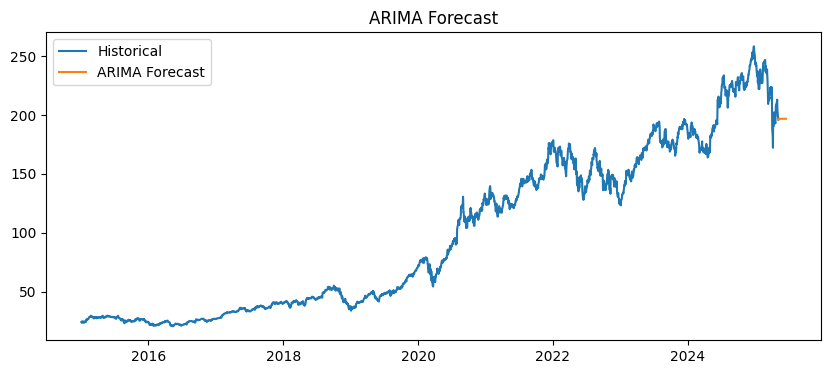

In [62]:
plt.figure(figsize=(10,4))
plt.plot(data['y'], label='Historical')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='B'), forecast_arima, label='ARIMA Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [64]:
model_sarima = SARIMAX(data['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
result_sarima = model_sarima.fit()
forecast_sarima = result_sarima.forecast(steps=30)

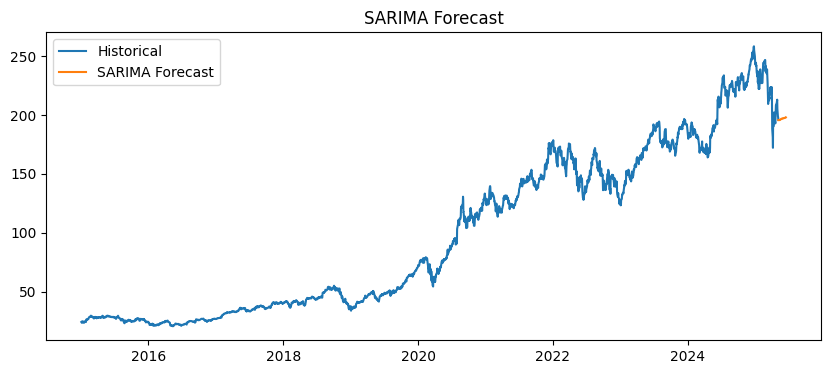

In [65]:
plt.figure(figsize=(10,4))
plt.plot(data['y'], label='Historical')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='B'), forecast_sarima, label='SARIMA Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [66]:
print(data.columns)
print(data.head())

MultiIndex([('y', 'AAPL')],
           names=['Price', 'Ticker'])
Price               y
Ticker           AAPL
ds                   
2015-01-02  24.288576
2015-01-05  23.604336
2015-01-06  23.606556
2015-01-07  23.937569
2015-01-08  24.857307


In [67]:
data.columns = data.columns.get_level_values(0) 
df_prophet = data.reset_index()
df_prophet = df_prophet.rename(columns={'ds': 'ds', 'y': 'y'})  
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')
df_prophet.dropna(inplace=True)

In [68]:
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

19:53:03 - cmdstanpy - INFO - Chain [1] start processing
19:53:03 - cmdstanpy - INFO - Chain [1] done processing


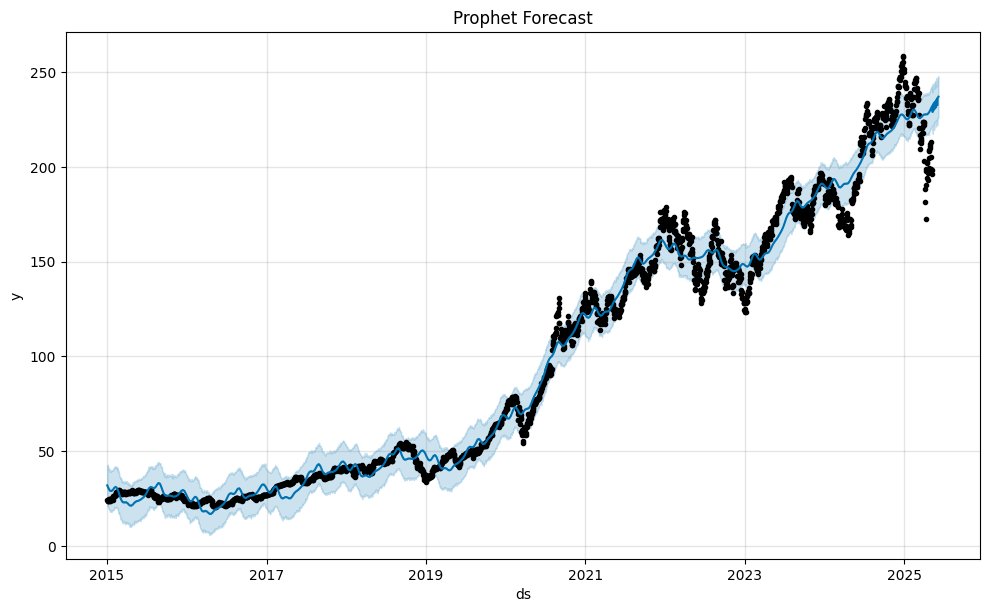

In [69]:
model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

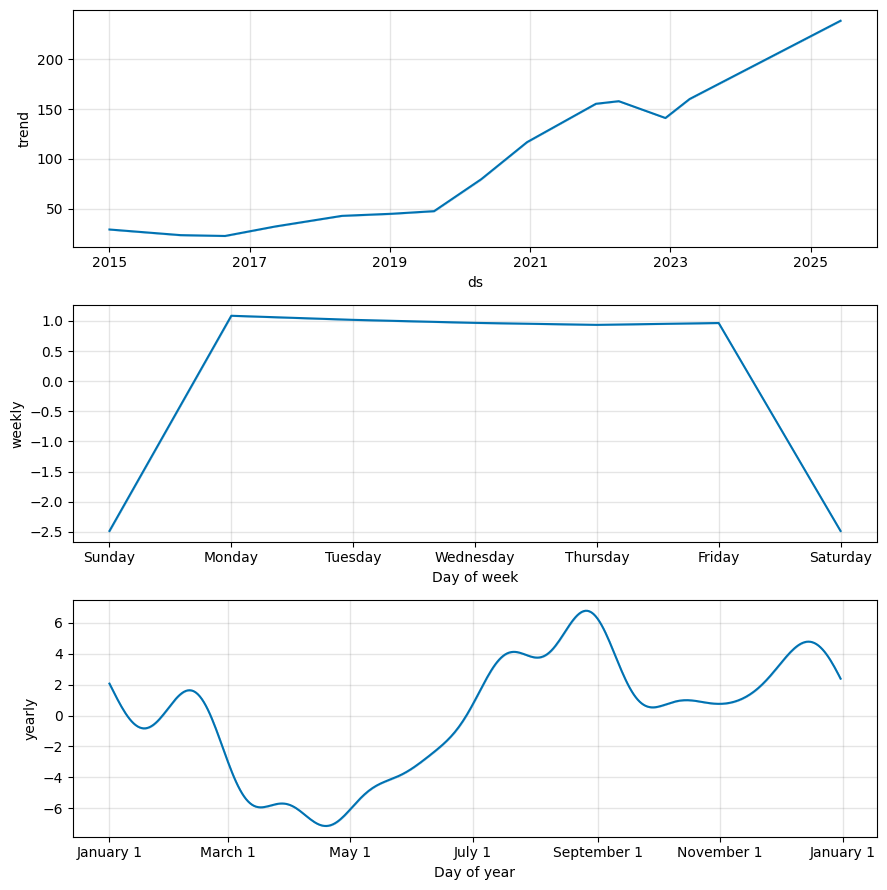

In [33]:
model.plot_components(forecast)
plt.show()

In [77]:
df_lstm = data[['y']].copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_lstm)
def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(seq_len, len(data)):
        x.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(x), np.array(y)
seq_len = 30
x, y_lstm = create_sequences(scaled, seq_len)

In [78]:
split = int(0.8 * len(x))
x_train, y_train = x[:split], y_lstm[:split]
x_test, y_test = x[split:], y_lstm[split:]

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_len, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0151
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0688e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4972e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4607e-04
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5129e-04
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2162e-04
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2584e-04
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4662e-04
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2771e-04
Epoch 10/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0414e-04


In [80]:
pred = model_lstm.predict(x_test)
pred_inv = scaler.inverse_transform(pred)
y_test_inv = scaler.inverse_transform(y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


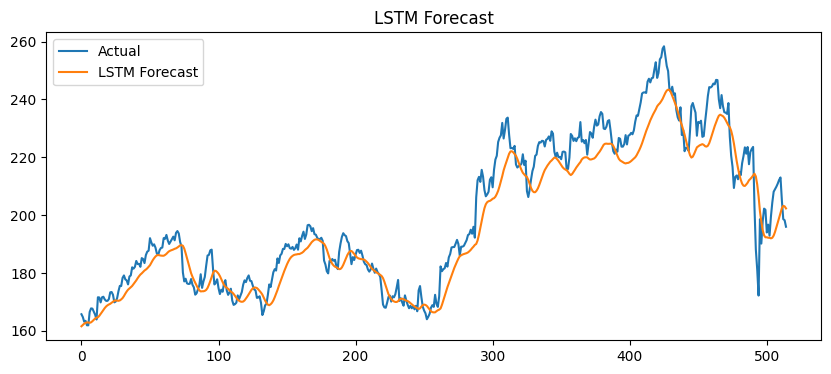

In [81]:
plt.figure(figsize=(10,4))
plt.plot(y_test_inv, label='Actual')
plt.plot(pred_inv, label='LSTM Forecast')
plt.title("LSTM Forecast")
plt.legend()
plt.show()

In [82]:
def evaluate(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
evaluate(y_test_inv, pred_inv, "LSTM")
evaluate(data['y'][-30:], forecast_arima[:30], "ARIMA")
evaluate(data['y'][-30:], forecast_sarima[:30], "SARIMA")
prophet_actual = df_prophet['y'].iloc[-30:].values
prophet_pred = forecast['yhat'].iloc[-30:].values
evaluate(prophet_actual, prophet_pred, "Prophet")

LSTM - MAE: 6.1456, RMSE: 7.9158
ARIMA - MAE: 11.2237, RMSE: 14.3250
SARIMA - MAE: 11.2226, RMSE: 14.4908
Prophet - MAE: 29.6475, RMSE: 32.3427
